## Analysis

In [62]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

# Impact Of Airline Tweets in the Sentiment Of A Conversation

Dataset of conversations & Dates as downloaded here
https://drive.google.com/open?id=13v22L7LXIElILm2M4vfdfeo9sMjyqIOM

In [15]:
df = pd.read_csv('rawdates.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
df['mean_sentiment'].astype(float, inplace=True).describe()

count    372429.000000
mean          0.542905
std           0.584006
min           0.000000
25%           0.000000
50%           0.500000
75%           1.000000
max           2.000000
Name: mean_sentiment, dtype: float64

In [29]:
df.head()

,Unnamed: 0,False,conversation_id,raw_tweets_info,conversation_length,tweet_ids,user_ids,airlines_involved,mean_sentiment,sentiments,full_text,dates
0,0,0,5,"[(747530773037780992, 31132554), (747526794446...",2,"[747526794446802944, 747530773037780992]","[22873368, 31132554]",['No airlines involved'],NaN,"[nan, 1]",['Hey @British_Airways our @easyJet flight Ven...,"['Mon Jun 27 20:27:30 +0000 2016', 'Mon Jun 27..."
1,1,1,6,"[(747530681509625860, 417945325), (74745123859...",2,"[747451238598475776, 747530681509625860]","[55904765, 417945325]",['No airlines involved'],0.0,"[0, 0]",['@easyJet thanks for looking after my luggage...,"['Mon Jun 27 15:27:16 +0000 2016', 'Mon Jun 27..."
2,2,2,11,"[(747530531475173376, 597673831), (74752831114...",2,"[747528311144734720, 747530531475173376]","[427951650, 597673831]",['No airlines involved'],0.5,"[1, 0]","[""@British_Airways I booked via Expedia. I'm n...","['Mon Jun 27 20:33:32 +0000 2016', 'Mon Jun 27..."
3,3,3,12,"[(747530509098450944, 1624311463), (7475297117...",2,"[747529711782244352, 747530509098450944]","[1624311463, 1624311463]",['No airlines involved'],0.0,"[0, 0]",['@easyJet is there anyway to travel with 2 ca...,"['Mon Jun 27 20:39:06 +0000 2016', 'Mon Jun 27..."
4,4,4,14,"[(747530348561571840, 154605692), (74752081839...",2,"[747520818398232576, 747530348561571840]","[117754884, 154605692]",['No airlines involved'],0.5,"[1, 0]",['@easyJet how nice of you not to reply to my ...,"['Mon Jun 27 20:03:46 +0000 2016', 'Mon Jun 27..."


## User sentiment before and after customer support

In [18]:
#helper functions
def append_row(df, entry):
    assert len(df.columns) == len(entry), "Not enough data"
    df2 = pd.DataFrame([entry,], columns=df.columns)
    return df.append(df2, ignore_index=True)

def time_delta(datestring1, datestring2):
    date1 = datetime.datetime.strptime(datestring1, '%a %b %d %H:%M:%S +0000 %Y')
    date2 = datetime.datetime.strptime(datestring2, '%a %b %d %H:%M:%S +0000 %Y')
    timedelta = date2 - date1
    return(timedelta.seconds)

In [144]:
def sentiment_vs_replytime(airline, airline_id, df):
    total = 0
    errors = 0
    
    #filter on specific airline
    if len(airline) == 1:
        df_airline = df[df['airlines_involved'] == f"['{airline[0]}']"]
        print(f"[{airline[0]}]")
        print(df_airline.shape)
    else:
        df_airline = df
    
    df_interaction = pd.DataFrame(columns=['replyTime', 'sentChange'])
    #find interactions
    for data in df_airline[['user_ids', 'sentiments', 'dates']].values:
        all_ids = eval(data[0])
        for i in range(0, len(all_ids)):
            if str(all_ids[i]) in airline_id:   
                #check wether index first or last and wether tweet before and after are same user
                if ((i != 0) and i != (len(eval(data[0])) -1)) and (all_ids[i-1] == all_ids[i+1]):
                    try:
                        total += 1
                        date1 = eval(data[2])[i-1]
                        date2 = eval(data[2])[i]
                        replytime = time_delta(date1, date2)

                        sentiments = eval(data[1])
                        sentiment_delta = int(sentiments[i+1] - sentiments[i-1])

                        df_interaction = append_row(df_interaction, [replytime, sentiment_delta])
                    except NameError:
                        errors += 1
                        pass
    
    print('errors: ' + str(errors))
    print('total: ' + str(total))
    return df_interaction

In [145]:
df_klm1 = sentiment_vs_replytime(["KLM"],["56377143"], df)
df_klm1['replyTime'].describe()

[KLM]
(37868, 12)
errors: 3409
total: 6159


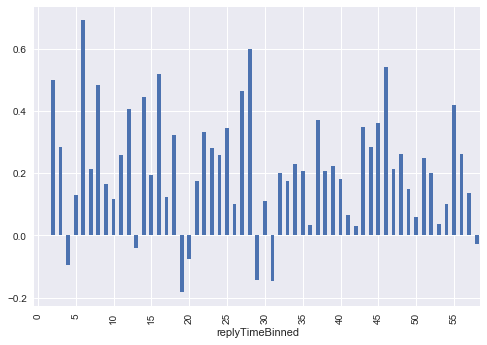

In [157]:
df_klm1['replyTime'] = df_klm1['replyTime'].astype('int64')
df_klm1['sentChange'] = df_klm1['sentChange'].astype('int64')
bins = [60*n for n in range(0, 60)]
df_klm1['replyTimeBinned'] = pd.cut(df_klm1['replyTime'], bins)
klm_grouped = df_klm1.groupby(by='replyTimeBinned')
klm_grouped['sentChange'].mean().plot(kind='bar')
plt.xticks([5*n for n in range(0, 12)],[5*n for n in range(0, 12)])
#klm_grouped['sentChange'].count().plot(kind='bar')
plt.show()

In [147]:
airline_names = ["KLM", "AirFrance", "British_Airways", "AmericanAir", "Lufthansa", 
"AirBerlin", "AirBerlin assist", "easyJet", "RyanAir", "SingaporeAir", 
"Qantas", "EtihadAirways", "VirginAtlantic"]
airline_ids = ["56377143", "106062176", "18332190", "22536055", 
"124476322", "26223583", "2182373406", "38676903", 
"1542862735", "253340062", "218730857", "45621423", "20626359"]

df_all = sentiment_vs_replytime(airline_names, airline_ids, df)
df_all['replyTime'].describe()

errors: 8974
total: 75605


count     66631
unique    15418
top         124
freq         68
Name: replyTime, dtype: int64

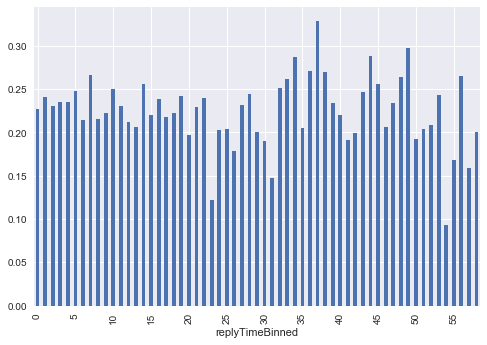

In [156]:
df_all['replyTime'] = df_all['replyTime'].astype('int64')
df_all['sentChange'] = df_all['sentChange'].astype('int64')
bins = [60*n for n in range(0, 60)]
df_all['replyTimeBinned'] = pd.cut(df_all['replyTime'], bins)
all_grouped = df_all.groupby(by='replyTimeBinned')
ax = all_grouped['sentChange'].mean().plot(kind='bar')
plt.xticks([5*n for n in range(0, 12)],[5*n for n in range(0, 12)])
#klm_grouped['sentChange'].count().plot(kind='bar')
plt.show()

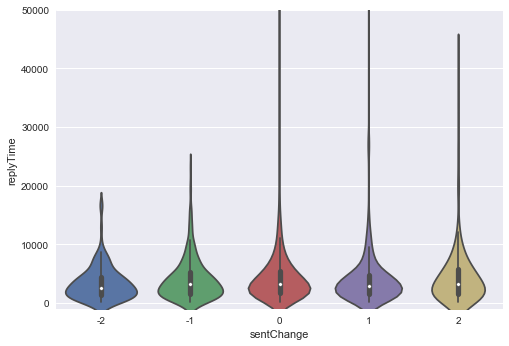

In [84]:
#df_klm1.plot(kind='violinplot', x='sentChange', y='replyTime')
#plt.show()

ax = sns.violinplot(x="sentChange", y="replyTime", data=df_klm1)
ax.set_ylim(-1000,50000)
plt.show()

In [17]:
airline_names = ["KLM", "AirFrance", "British_Airways", "AmericanAir", "Lufthansa", 
"AirBerlin", "AirBerlin assist", "easyJet", "RyanAir", "SingaporeAir", 
"Qantas", "EtihadAirways", "VirginAtlantic"]
airline_ids = ["56377143", "106062176", "18332190", "22536055", 
"124476322", "26223583", "2182373406", "38676903", 
"1542862735", "253340062", "218730857", "45621423", "20626359"]

improvement = []
for airline, airline_id in zip(airline_names, airline_ids):
    improv = get_improvement_tweets(airline, airline_id)
    improvement.append(improv)
    print(f'Improvement in convs that start negative: {round(improv, 2)}%')

[KLM]
Improvement in convs that start negative: 25.17%
[AirFrance]
Improvement in convs that start negative: 37.11%
[British_Airways]
Improvement in convs that start negative: 34.32%
[AmericanAir]
Improvement in convs that start negative: 29.45%
[Lufthansa]
Improvement in convs that start negative: 32.22%
[AirBerlin]
Improvement in convs that start negative: 22.52%
[AirBerlin assist]
Improvement in convs that start negative: 26.66%
[easyJet]
Improvement in convs that start negative: 40.53%
[RyanAir]
Improvement in convs that start negative: 48.83%
[SingaporeAir]
Improvement in convs that start negative: 52.67%
[Qantas]
Improvement in convs that start negative: 46.95%
[EtihadAirways]
Improvement in convs that start negative: 50.65%
[VirginAtlantic]
Improvement in convs that start negative: 38.4%


In [18]:
get_user_tweets('KLM', "56377143")

[KLM]


(0.5507914245642156, 0.734472049689441)

In [19]:
airline_names = ["KLM", "AirFrance", "British_Airways", "AmericanAir", "Lufthansa", 
"AirBerlin", "AirBerlin assist", "easyJet", "RyanAir", "SingaporeAir", 
"Qantas", "EtihadAirways", "VirginAtlantic"]
airline_ids = ["56377143", "106062176", "18332190", "22536055", 
"124476322", "26223583", "2182373406", "38676903", 
"1542862735", "253340062", "218730857", "45621423", "20626359"]

sent_before = []
sent_after = []
for airline, airline_id in zip(airline_names, airline_ids):
    sents = get_user_tweets(airline, airline_id)
    sent_before.append(sents[0])
    sent_after.append(sents[1])

[KLM]
[AirFrance]
[British_Airways]
[AmericanAir]
[Lufthansa]
[AirBerlin]
[AirBerlin assist]
[easyJet]
[RyanAir]
[SingaporeAir]
[Qantas]
[EtihadAirways]
[VirginAtlantic]


In [20]:
increase = np.array(sent_after)-np.array(sent_before)
perc_increase = (np.array(sent_after) - np.array(sent_before)) / np.array(sent_before) * 100


before_after = pd.DataFrame({'airline' : airline_names,
                             'sentiment_before' : sent_before,
                             'sentiment_after' : sent_after,
                             'increase' : increase.round(2),
                             'percentage_increase' : perc_increase.round(2),
                             'negative_improved' : improvement})
before_after = before_after.set_index('airline')
before_after

,increase,negative_improved,percentage_increase,sentiment_after,sentiment_before
airline,,,,,
KLM,0.18,25.169404,33.35,0.734472,0.550791
AirFrance,0.31,37.111390,57.91,0.834880,0.528704
British_Airways,0.22,34.318364,50.23,0.651680,0.433784
AmericanAir,0.28,29.447818,72.15,0.676917,0.393214
Lufthansa,0.15,32.217837,31.73,0.617401,0.468688
AirBerlin,0.24,22.522220,57.06,0.666018,0.424051
AirBerlin assist,0.23,26.658814,68.26,0.574305,0.341323
easyJet,0.31,40.532211,75.27,0.724343,0.413268
RyanAir,0.30,48.829466,56.16,0.828467,0.530522


Text(0,0.5,'Airline')

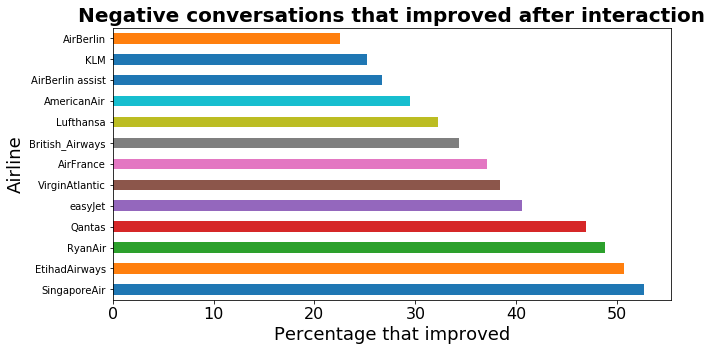

In [21]:
#selection = before_after.set_index('airline').filter(['SingaporeAir', 'KLM', 'British_Airways', 'AirBerlin'], axis=0)
before_after.sort_values(by='negative_improved', ascending=False)['negative_improved'].plot(kind='barh', 
                                                                                        figsize=(10,5))
plt.title('Negative conversations that improved after interaction', 
          weight='bold', fontsize=20)
plt.xlabel('Percentage that improved', fontsize=18)
plt.xticks(fontsize=16)
plt.ylabel('Airline', fontsize=18)
#plt.savefig('conv_perc_improvement_barh', dpi=300)

Text(0,0.5,'Airline')

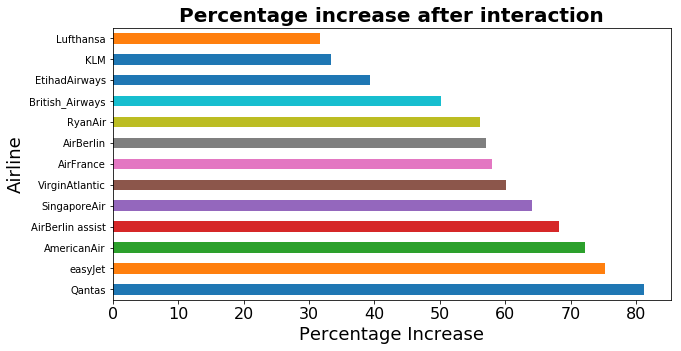

In [22]:
#selection = before_after.set_index('airline').filter(['Qantas', 'KLM', 'British_Airways', 'Lufthansa'], axis=0)

before_after.sort_values(by='percentage_increase', ascending=False)['percentage_increase'].plot(kind='barh', 
                                                                                        figsize=(10,5), rot=0)
plt.title('Percentage increase after interaction', 
          weight='bold', fontsize=20)
plt.xlabel('Percentage Increase', fontsize=18)
plt.xticks(fontsize=16)
plt.ylabel('Airline', fontsize=18)
#plt.savefig('percentage_increase_sentiment_barh', dpi=300)

Text(0,0.5,'Airline')

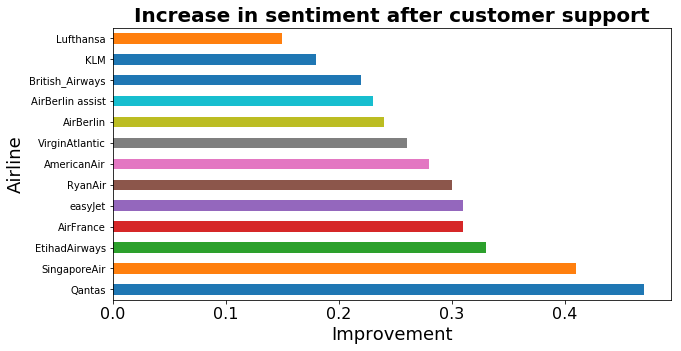

In [23]:
#selection2 = before_after.set_index('airline').filter(['SingaporeAir', 'KLM', 'British_Airways', 'AirBerlin'], axis=0)

before_after.sort_values(by='increase', ascending=False)['increase'].plot(kind='barh', 
                                                                              figsize=(10,5), rot=0)
plt.title('Increase in sentiment after customer support', 
          weight='bold', fontsize=20)
plt.xlabel('Improvement', fontsize=18)
plt.xticks(fontsize=16)
plt.ylabel('Airline', fontsize=18)
#plt.savefig('sentiment_increase_per_airline_barh.png', dpi=300)

IndexError: index 5 is out of bounds for axis 0 with size 5

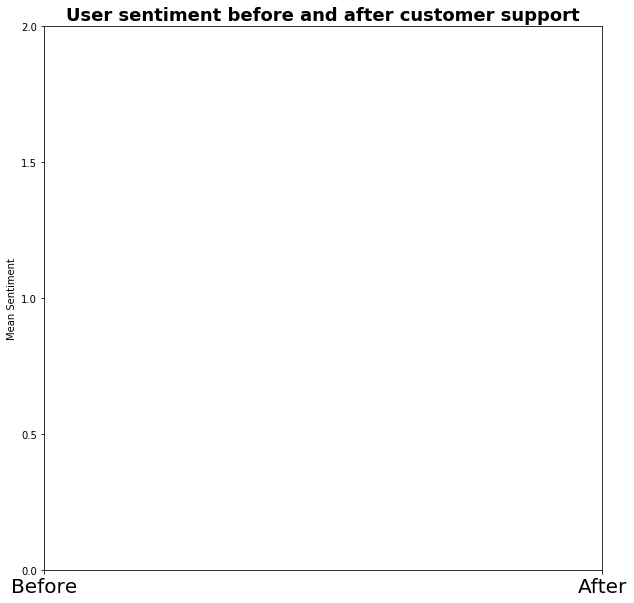

In [24]:
#selection3 = before_after.set_index('airline').filter(['SingaporeAir', 'KLM', 'British_Airways', 'AirBerlin'], axis=0)

plt.figure(figsize=(10,10))
plt.title('User sentiment before and after customer support', weight='bold', fontsize=18)
plt.xticks([0,1], ('Before', 'After'), fontsize=20)
plt.ylim(0,2)
plt.yticks([0,0.5,1,1.5,2])
plt.ylabel('Mean Sentiment')
for row in before_after.values:
    plt.plot([row[5],row[4]])
plt.legend(airline_names);

## Check conversations

In [ ]:
import sqlite3
import pandas as pd
conn = sqlite3.connect('full_conversation_database.db')
text_df = pd.read_sql("SELECT id_str, text FROM tweets", conn)

In [ ]:
text_df.head()

In [ ]:
conv = df.iloc[20288]['tweet_ids']
for tweet in eval(conv):
    print(str(text_df[text_df['id_str'] == str(tweet)]['text'].item()))

# Conversation 20288


# Positive - Thank you, You're welcome, :)

# Neutral - Willing, availability, business class, markets, prescription medications
# Short tweets, unemotional tweets, no indication of biased words

# Negative - Help, Customs, site down, won't load, issues, resolve
# (too) hard, :(, disappointed, sorry, bad, limited, worthless,
# impossible, sucks, chasing, away, zeroed, 0, finally, cost, uncertainty, frustration, ruined, missing, afraid,
# resolved, damage, negative, regret, inconvenience, 

In [ ]:
#for tweet in text_df['text']:
#    if 'XOXO' in tweet:
#        print(tweet)